# Use VAEs to compress segmented microbiome datasets from lab microbiome (of relative abundance)

Author: Zhengqing Zhou
Updated: 2025/06/13

In this notebook, we test whether a low-dimensional embedding can predict community structure shift.

In [ ]:
# We begin by importing the essentials
import numpy as np
import matplotlib.pyplot as plt

# We also setup torch for later usage.
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from torch.nn import functional as F
from torch import nn

import time as timer

# Configure GPU if available
if torch.cuda.is_available():

    device = "cuda:0"
else:
    device = "cpu"

display(device)

# VAE Network
The VAE network has 16 channels in the encoder, consisting of 3 convolutional layers, each followed by a leaky relu function, with kernel = 3, strid = 1, and padding = 1, so the time series (length of 30) will not get shortened during the convolutions; and two parallel linear layers to project the encoded time series to the mean value and var of the latent dimension, based on which a gaussian sampling will be done, generating the embedding of the data. The embedding is further decoded by a decoder of the symmetrical structure.

In [2]:
class VAE(nn.Module):

    def __init__(self, n_target, latent_dim):
        # Call parent model constructor and store hidden state variables.
        super().__init__()
        self.latent_dim = latent_dim
        self.n_target = n_target
        self.channels = 16

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=self.n_target, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
        )

        self.mean_map = nn.Linear(self.channels * 30, self.latent_dim)

        self.std_map = nn.Linear(self.channels * 30, self.latent_dim)

        self.fc_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.channels * 30),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.n_target, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU()
        )

    def sample(self, mean, log_var):
        """Sample a given N(0,1) normal distribution given a mean and log of variance."""

        # First compute the variance from the log variance.
        var = torch.exp(0.5 * log_var)

        # Compute a scaled distribution
        eps = torch.randn_like(var)

        # Add the vectors
        z = mean + var * eps

        return z

    def forward(self, X):
        """Forward propogate through the model, return both the reconstruction and sampled mean and standard deviation
        for the system.
        """
        pre_code = self.encoder(X)
        B, C, L = pre_code.shape
        flattened = pre_code.view(B, C * L)

        mu = self.mean_map(flattened)
        log_var = self.std_map(flattened)

        code = self.sample(mu, log_var)

        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat, code, mu, log_var


def vae_loss(x_hat, x, mu, log_var):
    "Compute the sum of BCE and KL loss for the distribution."

    # weight for the KL divergence
    alpha = 1e-4

    # Compute the reconstruction loss
    BCE = F.mse_loss(x_hat, x)

    # Compute the KL divergence of the distribution.
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + alpha * KLD

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Classification: use the embedding to determine if it can predict the community shifts > 0.3

In [4]:
class VAE_MLP(torch.nn.Module):
    
    def __init__(self, VAE, n_embedding, n_asv):
        super().__init__()
        
        self.channels = 32

        self.encoder = VAE.encoder.eval()
        self.mean_map = VAE.mean_map.eval()
        self.std_map = VAE.std_map.eval()
        self.mlp = nn.Sequential(
            nn.Linear(n_asv*n_embedding,self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels,self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels,1),
        )

        
        # Freeze the parameters of the VAE
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.mean_map.parameters():
            param.requires_grad = False
        for param in self.std_map.parameters():
            param.requires_grad = False
            
    def sample(self, mean, log_var):
        """Sample a given N(0,1) normal distribution given a mean and log of variance."""

        # First compute the variance from the log variance.
        var = torch.exp(0.5*log_var)

        # Compute a scaled distribution
        eps = torch.randn_like(var)

        # Add the vectors
        z = mean + var*eps

        return z
    
    def forward(self, Xs, n_asv):
        """Forward propogate through the model, return both the reconstruction and sampled mean and standard deviation
        for the system.
        """
        
        embedding = []
        for i in range(n_asv):
            X = Xs[:,i:i+1,:]
            
            pre_code = self.encoder(X)
            B, C, L = pre_code.shape
            flattened = pre_code.view(B, C * L)

            mu = self.mean_map(flattened)
            log_var = self.std_map(flattened)

            code = self.sample(mu, log_var)
            embedding.append(code)
        
        embedding = torch.cat(embedding,dim=1)

        b_div = self.mlp(embedding).squeeze()

        return b_div

In [5]:
class CommShiftDataset(torch.utils.data.Dataset):
    
    def __init__(self, segment, b_div):
        
        self.X = segment
        self.Y = b_div
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        
        return self.X[idx], self.Y[idx]

def get_collapse_data(sample,n_asv,threshold=0.3):
    ts_data = np.load(f"./lab_microbiome_datasets_CV/ranked/{sample}_ranked_relative.npy")
    abruptness = np.loadtxt(
        f"./community_shift/{sample}_abruptness.txt")
    Segments = []
    BDIV = []#beta-diversity
    T = 30
    for start in range(ts_data.shape[1] - T - 5):
        seg = ts_data[:,start:start + T,0:n_asv]
        bdiv = abruptness[:,start+T-1]
        Segments.append(seg)
        BDIV.append(bdiv)
    Segments = np.array(Segments) # shape (x,8,30,n_asv)
    Segments = np.transpose(Segments, axes=(1,0,3,2)) # shape (8,x,n_asv,30)

    BDIV = np.array(BDIV) # shape (x,8)
    BDIV = np.transpose(BDIV, axes=(1,0))
    
    collapse = (BDIV > threshold).astype(np.int64)

    return Segments,collapse

In [6]:
def train_model(model, data_loader, optimizer, criterion, n_asv):
    model.train()
    total_loss = 0.0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device).float()   # BCE expects float targets

        optimizer.zero_grad()
        logits = model(x, n_asv).squeeze(dim=-1)    # (batch,)  or (batch,1)
        loss = criterion(logits, y)                 # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)
    
def test_model(model, data_loader, criterion, n_asv):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device).float()
            logits = model(x, n_asv).squeeze(dim=-1)
            loss = criterion(logits, y)
            total_loss += loss.item()

    return total_loss / len(data_loader)


In [7]:
import math
def run_collapse_cv(sample, n_asv, threshold, trial):
    torch.manual_seed(10*n_asv+trial)
    lr0       = 1e-3
    EPOCHS    = 40
    batch_sz  = 16
    lr_decay  = 0.98

    # ── Load pretrained VAE ──────────────────────────────────────────────
    Ec      = int(np.ceil(np.loadtxt(f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec.txt")[1, 0]))
    vae     = VAE(1, Ec)
    vae.load_state_dict(torch.load(f"./vae_models_CV/{sample}_T1_E{Ec}_full.pth",
                                   weights_only=True))
    vae.eval().to(device)

    # ── Load full dataset ────────────────────────────────────────────────
    Segments, P = get_collapse_data(sample, n_asv, threshold)

    all_train_losses, all_test_losses = [], []

    for i in range(8):
        print(f"\n=== Fold {i+1}/8 ===")

        # ----- split -----
        X_test  = torch.tensor(Segments[i]).float()
        y_test  = torch.tensor(P[i]).float()
        X_train = torch.tensor(np.vstack([Segments[j] for j in range(8) if j != i])).float()
        y_train = torch.tensor(np.hstack([P[j] for j in range(8) if j != i])).float()

        train_ds = CommShiftDataset(X_train, y_train)
        test_ds  = CommShiftDataset(X_test,  y_test)
        train_ld = DataLoader(train_ds, batch_size=batch_sz, shuffle=True)
        test_ld  = DataLoader(test_ds,  batch_size=batch_sz, shuffle=False)

        # ----- pos_weight -----
        n_pos = (y_train == 1).sum()       # assumes labels are 0/1
        n_neg = y_train.numel() - n_pos
        pos_w = (n_neg / n_pos).clamp(max=30)   # optional clip for stability
        criterion = torch.nn.BCEWithLogitsLoss(
            pos_weight=pos_w.to(device)         # scalar tensor
        )

        # ----- model & optimiser -----
        model     = VAE_MLP(vae, Ec, n_asv).float().to(device)
        print("MLP-VAE parameters = %1.1e" % count_parameters(model))
        optimiser = torch.optim.Adam(model.mlp.parameters(), lr=lr0)

        # ----- training -----

        # ----- class balance -------------------------------------------------
        num_pos_train = y_train.sum().item()
        num_neg_train = y_train.numel() - num_pos_train
        p_train = num_pos_train / (num_pos_train + num_neg_train)
        
        num_pos_test  = y_test.sum().item()
        num_neg_test  = y_test.numel()  - num_pos_test
        p_test  = num_pos_test / (num_pos_test + num_neg_test)
        
        # ----- weighted-entropy baselines ------------------------------------
        eps = 1e-9                                    # numerical guard
        def weighted_ce(p):                           # binary entropy *with* pos_weight
            return -(pos_w * p * math.log(p + eps) +
                     (1 - p) * math.log(1 - p + eps))
        
        baseline_ce_train = weighted_ce(p_train)
        baseline_ce_test  = weighted_ce(p_test)
        
        print(f"{sample}, Fold {i+1}:  "
              f"train positives = {p_train:.1%},  "
              f"test positives = {p_test:.1%},  "
              f"baseline CE  (train | test) = {baseline_ce_train:.3f} | {baseline_ce_test:.3f}")

        train_losses, test_losses = [], []
        for epoch in trange(EPOCHS, desc=f"Fold {i+1}", leave=False):
            tr_loss = train_model(model, train_ld, optimiser, criterion, n_asv)
            te_loss = test_model(model,  test_ld,  criterion, n_asv)
            train_losses.append(tr_loss); test_losses.append(te_loss)

            # optional LR decay
            for g in optimiser.param_groups:
                g['lr'] *= lr_decay

        print(f"Finished: train={tr_loss:.2e}, test={te_loss:.2e}")
        torch.save(model.state_dict(),
                   f"./mlp_models/collapse_classification/{sample}_{n_asv}ASV_fold{i+1}_threshold{threshold}_trial{trial}.pth")

        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
    return all_train_losses,all_test_losses


In [ ]:
import time as timer
sample="Water-A"
n_asv = 2
collapse_threshold = 0.3
trial = 1
t0=timer.perf_counter()
train_losses, test_losses = run_collapse_cv(sample,n_asv,collapse_threshold,trial)
train_time=timer.perf_counter()-t0
print("training finished, time used: %i s"%train_time)

In [ ]:
fig,axes=plt.subplots(2,4,figsize=(8,4))
axes=axes.flat
for i in range(8):
    ax=axes[i]
    ax.plot(train_losses[i],label="train")
    ax.plot(test_losses[i],label="test")
    #ax.set_yscale("log")
axes[0].legend()
fig.tight_layout()
plt.show()

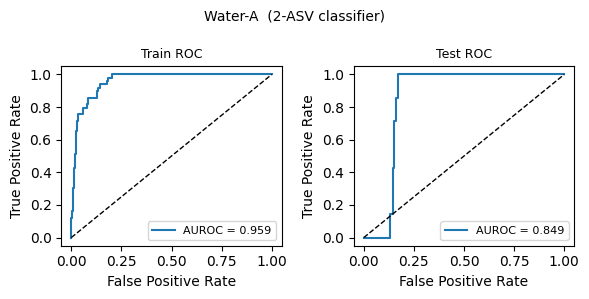

In [11]:
from sklearn.metrics import roc_curve, auc

device = "cuda:0"
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
ax_train, ax_test = axes

# ── load pretrained VAE once ───────────────────────────────────────────
Ec = int(np.ceil(np.loadtxt(
        f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec.txt")[1, 0]))
vae = VAE(1, Ec)
vae.load_state_dict(torch.load(
        f"./vae_models_CV/{sample}_T1_E{Ec}_full.pth",
        weights_only=True))
vae.eval().to(device)

# ── aggregate over the 8 CV folds ──────────────────────────────────────
y_train_all, y_test_all   = [], []
prob_train_all, prob_test_all = [], []

Segments, P = get_collapse_data(sample, n_asv, collapse_threshold)   # classification labels (0/1)

for i in range(8):
    # split data exactly as in training
    X_test  = torch.tensor(Segments[i]).float().to(device)
    y_test  = torch.tensor(P[i]).float()
    X_train = torch.tensor(np.vstack([Segments[j] for j in range(8) if j != i]),
                           dtype=torch.float32).to(device)
    y_train = torch.tensor(np.hstack([P[j] for j in range(8) if j != i])).float()

    # load fold-specific classifier
    clf = VAE_MLP(vae, Ec, n_asv).float().to(device)
    clf.load_state_dict(torch.load(
        f"./mlp_models/collapse_classification/{sample}_{n_asv}ASV_fold{i+1}_threshold{collapse_threshold}_trial{trial}.pth",
        weights_only=True))
    clf.eval()

    with torch.no_grad():
        logits_train = clf(X_train, n_asv).cpu()
        logits_test  = clf(X_test,  n_asv).cpu()

    prob_train_all.append(torch.sigmoid(logits_train))
    prob_test_all.append(torch.sigmoid(logits_test))
    y_train_all.append(y_train)
    y_test_all.append(y_test)

# ── concatenate over folds ────────────────────────────────────────────
y_train_all   = torch.cat(y_train_all).numpy()
y_test_all    = torch.cat(y_test_all).numpy()
prob_train_all = torch.cat(prob_train_all).numpy()
prob_test_all  = torch.cat(prob_test_all).numpy()

# ── ROC + AUROC + Accuracy ────────────────────────────────────────────
def plot_roc(ax, y_true, y_score, title, thresh=0.5):
    # ROC curve + AUROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    au = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=1.5, label=f"AUROC = {au:.3f}")

    # Chance line
    ax.plot([0, 1], [0, 1], "k--", lw=1)

    # Cosmetics
    ax.set_xlim([-0.05, 1.05]); ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.set_title(title, fontsize=9)
    ax.legend(loc="lower right", fontsize=8)

# ── draw both panels ──────────────────────────────────────────────────
plot_roc(ax_train, y_train_all, prob_train_all, "Train ROC")
plot_roc(ax_test,  y_test_all,  prob_test_all,  "Test ROC")

fig.suptitle(f"{sample}  ({n_asv}-ASV classifier)", fontsize=10)
plt.tight_layout()
plt.show()


### load the trained models to perform analysis
**analyses below this point requires downloading the entire dataset from Zenodo.**

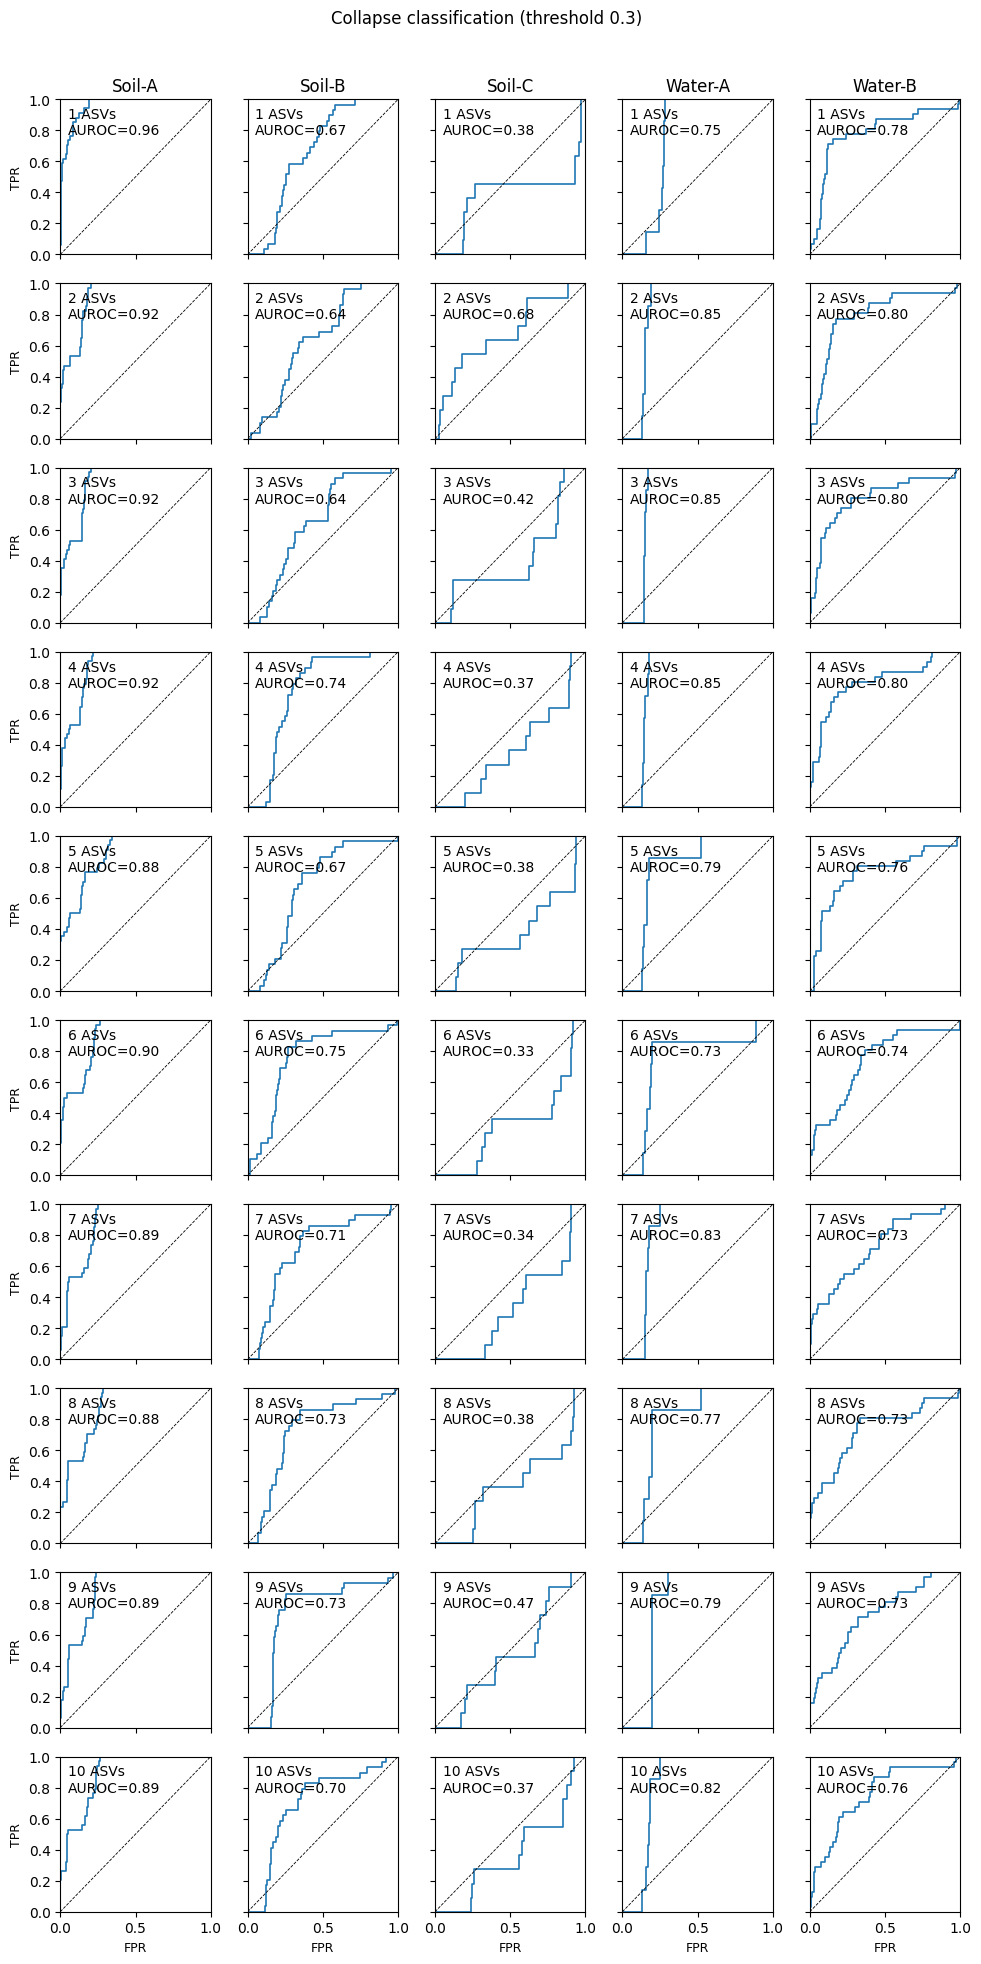

In [17]:
import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

device   = "cuda:0"
threshold = 0.3         # same threshold you used when generating labels
samples   = ["Soil-A", "Soil-B", "Soil-C", "Water-A", "Water-B"]
n_asvs    = range(1, 11)               # 1 … 10 rows
trial = 2

fig, axes = plt.subplots(len(n_asvs), len(samples),
                         figsize=(2*len(samples), 2*len(n_asvs)), sharex=True, sharey=True)

for col, sample in enumerate(samples):
    # --- load the VAE for this inoculum/medium just once -------------
    Ec = int(np.ceil(np.loadtxt(
        f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec.txt")[1, 0]))
    vae = VAE(1, Ec)
    vae.load_state_dict(torch.load(
        f"./vae_models_CV/{sample}_T1_E{Ec}_full.pth", weights_only=True))
    vae.eval().to(device)

    for row, n_asv in enumerate(n_asvs, start=0):
        ax = axes[row, col]

        # --------------------------------------------------------------
        # 1. load dataset for this n_asv, split exactly as in training
        # --------------------------------------------------------------
        Seg, P = get_collapse_data(sample, n_asv, threshold)  # list length 8
        y_all, prob_all = [], []

        for fold in range(8):
            # hold-out replicate = fold
            X_test  = torch.tensor(Seg[fold]).float().to(device)
            y_test  = torch.tensor(P[fold]).float()

            # fold-specific classifier
            clf = VAE_MLP(vae, Ec, n_asv).float().to(device)
            clf.load_state_dict(torch.load(
                f"./mlp_models/collapse_classification/"
                f"{sample}_{n_asv}ASV_fold{fold+1}_threshold{threshold}_trial{trial}.pth",
                weights_only=True))
            clf.eval()

            with torch.no_grad():
                logits = clf(X_test, n_asv).cpu()
                prob   = torch.sigmoid(logits)

            y_all.append(y_test)
            prob_all.append(prob)

        y_all   = torch.cat(y_all).numpy()
        prob_all = torch.cat(prob_all).numpy()

        # save data
        data = np.vstack([y_all,prob_all]).T
        np.savetxt(f"./collapse_forecast_results/{sample}_{n_asv}ASV_threshold={threshold}_trial{trial}.txt",data)

        # --------------------------------------------------------------
        # 2. ROC curve, AUROC
        # --------------------------------------------------------------
        fpr, tpr, _ = roc_curve(y_all, prob_all)
        au  = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=1.2)
        ax.plot([0, 1], [0, 1], "k--", lw=0.6)
        ax.text(0.05, 0.95,
                f"{n_asv} ASVs\nAUROC={au:.2f}",
                transform=ax.transAxes, va="top", fontsize=10)
        ax.set_xlim([0, 1]); ax.set_ylim([0, 1])

        if row == len(n_asvs)-1:
            ax.set_xlabel("FPR", fontsize=9)
        if col == 0:
            ax.set_ylabel("TPR", fontsize=9)
        if row == 0:
            ax.set_title(sample)

fig.suptitle(f"Collapse classification (threshold {threshold})", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
